In [67]:
import numpy as np

# Define file paths for ease of access
decode_input_path = "C:/Users/prana/Desktop/Fall 23/Adv ML/LAB1/CRF-master/data/decode_input.txt"
train_struct_path = "C:/Users/prana/Desktop/Fall 23/Adv ML/LAB1/CRF-master/data/train_struct.txt"
model_path = "C:/Users/prana/Desktop/Fall 23/Adv ML/LAB1/CRF-master/data/model.txt"
train_data_path = "C:/Users/prana/Desktop/Fall 23/Adv ML/LAB1/CRF-master/data/train.txt"
test_data_path = "C:/Users/prana/Desktop/Fall 23/Adv ML/LAB1/CRF-master/data/test.txt"

def read_decode_input(file_path = "C:/Users/prana/Desktop/Fall 23/Adv ML/LAB1/CRF-master/data/decode_input.txt"):
    """
    Reads the decode_input data from the file.
    Each line represents one letter with 128 elements.
    There are 26 weight vectors each with 128 elements and a transition matrix T with size 26x26.
    The transition matrix T is in row-major order.
    """
    with open(file_path, "r") as f:
        raw_data = f.read().split("\n")

    X = np.array(raw_data[:100 * 128], dtype=float).reshape(100, 128)
    W = np.array(raw_data[100 * 128:100 * 128 + 26 * 128], dtype=float).reshape(26, 128)
    T = np.array(raw_data[100 * 128 + 26 * 128:-1], dtype=float).reshape(26, 26)
    T = np.swapaxes(T, 0, 1)
    
    print("Shapes of decode input:")
    print("X:", X.shape, "W:", W.shape, "T:", T.shape)
    #print("Top 5 rows of X:\n", X[:5])

    return X, W, T

def read_train_struct(file_path = "C:/Users/prana/Desktop/Fall 23/Adv ML/LAB1/CRF-master/data/train_struct.txt"):
    """
    Reads the train_struct data from the file.
    Each line represents a label and a feature vector (in a sparse representation).
    """
    with open(file_path, "r") as f:
        raw_data = f.read().split("\n")

    dataX, dataY = [], []
    for line in raw_data[:-1]:  # The last element is empty
        line = line.split(" ")
        dataY.append([int(line[0]) - 1, int(line[1][4:])])
        datax = np.zeros(128, dtype=int)
        for f1 in line[2:]:
            idx, val = f1.split(":")
            datax[int(idx) - 1] = int(val)
        dataX.append(datax)
    
    dataX_np = np.array(dataX, dtype=int)
    print("Shapes of train_struct:")
    print("dataX:", dataX_np.shape, "dataY length:", len(dataY))
    #print("Top 5 rows of dataX:\n", dataX_np[:5])
    
    return dataX_np, dataY

def read_model(file_path = "C:/Users/prana/Desktop/Fall 23/Adv ML/LAB1/CRF-master/data/model.txt"):
    """
    Reads the model data from the file.
    The data consists of weight vectors for each label and a transition matrix T.
    """
    with open(file_path, "r") as f:
        raw_data = f.read().split("\n")

    W = np.array(raw_data[:26 * 128], dtype=float).reshape(26, 128)
    T = np.array(raw_data[26 * 128:-1], dtype=float).reshape(26, 26)
    T = np.swapaxes(T, 0, 1)
    
    print("Shapes of model data:")
    print("W:", W.shape, "T:", T.shape)
    #print("Top 5 rows of W:\n", W[:5])
    
    return W, T

def read_train(file_path = "C:/Users/prana/Desktop/Fall 23/Adv ML/LAB1/CRF-master/data/train.txt"):
    """
    Reads the train data from the file.
    Each row corresponds to an example and is split into the label and the feature vector.
    """
    from string import ascii_lowercase
    mapping = {letter: idx for idx, letter in enumerate(ascii_lowercase)}

    with open(file_path, "r") as f:
        raw_data = f.read().split("\n")

    dataX, dataY = [], []
    tempX, tempY = [], []
    for row in raw_data[:-1]:
        row = row.split(" ")
        tempY.append(mapping[row[1]])
        tempX.append(np.array(row[5:], dtype=float))
        if int(row[2]) < 0:  # End of sequence
            dataX.append(np.array(tempX))
            dataY.append(np.array(tempY, dtype=int))
            tempX, tempY = [], []  # Reset for the next sequence

    print("Number of training sequences:", len(dataX))
    print("First 5 sequences' labels:\n", dataY[:5])
    
    return list(zip(dataX, dataY))

import numpy as np

def read_test(file_path = "C:/Users/prana/Desktop/Fall 23/Adv ML/LAB1/CRF-master/data/test.txt"):
    """
    Reads the test data from the file.
    Each row corresponds to an example and is split into the label and the feature vector.
    The function assumes that each example ends when a row with the third column less than 0 is encountered.
    """
    from string import ascii_lowercase
    mapping = {letter: idx for idx, letter in enumerate(ascii_lowercase)}

    with open(file_path, "r") as f:
        raw_data = f.read().split("\n")

    dataX, dataY = [], []
    tempX, tempY = [], []
    for row in raw_data[:-1]:  # Skip the last empty line if it exists
        row = row.split(" ")
        tempY.append(mapping[row[1]])
        tempX.append(np.array(row[5:], dtype=float))
        if int(row[2]) < 0:  # Check for the end of a sequence
            dataX.append(np.array(tempX))
            dataY.append(np.array(tempY, dtype=int))
            tempX, tempY = [], []  # Reset for the next sequence

    print("Number of test sequences:", len(dataX))
    print("First 5 sequences' labels:\n", dataY[:5])

    return list(zip(dataX, dataY))

def read_test_decoder_modified(file_path = "C:/Users/prana/Desktop/Fall 23/Adv ML/LAB1/CRF-master/data/decode_input.txt"):
    """
    Reads the test data for decoding and returns a NumPy array
    where each sub-array from the list becomes a row in the final
    two-dimensional array. This function only extracts the features
    and does not deal with the labels.
    """
    with open(file_path, 'r') as file:
        raw_data = file.read().strip().split('\n')

    # Initialize an empty list to store all feature vectors
    dataX = []
    
    for row in raw_data:
        if row:  # Skip any empty lines
            features = row.split(' ')[5:]  # Features start from the 6th element in the row
            feature_vector = list(map(float, features))  # Convert string features to float
            dataX.append(feature_vector)

    # Convert the list of lists (features for each word) into a 2D NumPy array
    dataX_np = np.array(dataX)

    print("Shape of test data for decoder:", dataX_np.shape)
    print("Top 5 feature vectors:\n", dataX_np[:5, :])

    return dataX_np

In [68]:
import math
import numpy as np

# This is prob_grad.py

def compute_log_p(X, y, W, T):
    """
    Computes the log probability of a sequence of labels given inputs X and parameters W, T.
    
    Parameters:
    X : 2D array where each row is the feature vector for one observation.
    y : 1D array of labels corresponding to the observations in X.
    W : Weight matrix where each row corresponds to the weights for one label.
    T : Transition matrix where T[i, j] is the transition weight from label i to label j.
    
    Returns:
    log probability of the label sequence given the inputs and parameters.
    """

    alpha_len = 26  # Alphabet size; ideally passed as a parameter for flexibility
    
    # Initialize the sum of numerator terms for log probability calculation
    sum_num = numpy.dot(W[y[0]], X[0])  # Initial state score
    for i in range(1, X.shape[0]):
        # Add scores for observed states and transitions
        sum_num += numpy.dot(W[y[i]], X[i]) + T[y[i-1], y[i]]
    
    # Initialize the forward trellis for dynamic programming
    trellisfw = numpy.zeros((X.shape[0], alpha_len))
    # Temporary storage for computations at each step
    interior = numpy.zeros(alpha_len)
    # Messages used in the forward pass for dynamic programming
    messages = numpy.zeros((26, 26))

    # Compute forward messages
    for i in range(1, X.shape[0]):
        # Compute interior scores based on current observation and previous states
        numpy.matmul(W, X[i-1], out=interior)
        numpy.add(interior, trellisfw[i-1], out=interior)
        # Compute messages for all transitions
        numpy.add(T, interior[:, numpy.newaxis], out=messages)
        # Normalize to avoid numerical instability
        maxes = messages.max(axis=0)
        numpy.add(messages, -1*maxes, out=messages)
        numpy.exp(messages, out=messages)
        # Sum messages to compute new state values
        numpy.sum(messages, axis=0, out=interior)
        numpy.log(interior, out=interior)
        # Update trellis with log-sums
        numpy.add(maxes, interior, out=trellisfw[i])

    # Compute final scores
    dots = numpy.matmul(W, X[-1])
    numpy.add(dots, trellisfw[-1], out=interior)

    # Normalize final log-sum to prevent underflow
    M = numpy.max(interior)
    numpy.add(interior, -1*M, out=interior)
    numpy.exp(interior, out=interior)
    
    # Calculate log partition function (log Z)
    log_z = M + math.log(numpy.sum(interior))

    # Return the log probability as difference of scores and log partition function
    return sum_num - log_z

import numpy as np
import math

def fb_prob(X, W, T):
    """
    Forward-backward algorithm to compute probabilities over label sequences.
    
    Parameters:
    - X: Input features for each observation in the sequence. Shape: [sequence_length, num_features]
    - W: Weight matrix for label features. Shape: [num_labels, num_features]
    - T: Transition matrix between labels. Shape: [num_labels, num_labels]
    
    Returns:
    - trellisfw: Forward probabilities. Shape: [sequence_length, num_labels]
    - trellisbw: Backward probabilities. Shape: [sequence_length, num_labels]
    - log_z: Log partition function, scalar.
    """
    sequence_length, num_features = X.shape
    num_labels = W.shape[0]
    
    # Initialize forward and backward trellises
    trellisfw = np.zeros((sequence_length, num_labels))
    trellisbw = np.zeros_like(trellisfw)
    
    # Forward pass
    for i in range(1, sequence_length):
        # Compute the weighted input features for all labels at this step
        weighted_inputs = np.dot(W, X[i-1])
        # Update the trellis with contributions from transitions and previous states
        for j in range(num_labels):
            transition_scores = T[:, j] + trellisfw[i-1]
            trellisfw[i, j] = log_sum_exp(weighted_inputs + transition_scores)
    
    # Backward pass
    trellisbw[-1, :] = 0  # Log-probability of 1 at the end of the sequence
    for i in range(sequence_length - 2, -1, -1):
        # Similar to forward pass but in reverse
        weighted_inputs = np.dot(W, X[i+1])
        for j in range(num_labels):
            transition_scores = T[j, :] + weighted_inputs
            trellisbw[i, j] = log_sum_exp(transition_scores + trellisbw[i+1])
    
    # Compute log partition function using the forward trellis
    final_forward_scores = np.dot(W, X[-1]) + trellisfw[-1]
    log_z = log_sum_exp(final_forward_scores)
    
    return trellisfw, trellisbw, log_z

def log_sum_exp(scores):
    """
    Numerically stable computation of log-sum-exp.
    
    Parameters:
    - scores: Input array of scores to be summed in log-space.
    
    Returns:
    - result: Log-sum-exp of input scores.
    """
    max_score = np.max(scores)
    return max_score + np.log(np.sum(np.exp(scores - max_score)))


# The following functions compute gradients for the weight matrix W and transition matrix T respectively
# given a single example (X, y), where X is the feature matrix for the sequence and y is the corresponding label sequence.

def log_p_wgrad(W, X, y, T):
    """
    Computes the gradient of the log probability with respect to the weight matrix W.
    
    Parameters:
    W : Weight matrix where each row corresponds to the weights for one label.
    X : 2D array where each row is the feature vector for one observation.
    y : 1D array of labels corresponding to the observations in X.
    T : Transition matrix where T[i, j] is the transition weight from label i to label j.
    
    Returns:
    Gradient of the log probability with respect to W.
    """
    grad_W = np.zeros(W.shape)  # Gradient matrix for W
    trellisfw, trellisbw, log_z = fb_prob(X, W, T)

    # Iterate over the sequence
    for i in range(X.shape[0]):
        # Combine forward and backward messages
        marginal = trellisfw[i] + trellisbw[i]
        # Incorporate the evidence from input features
        evidence = np.matmul(W, X[i])
        # Subtract the log partition function
        marginal -= log_z
        # Normalize to get probabilities
        marginal = np.exp(marginal)

        # Calculate the gradient for the current position
        for j in range(26):  # Iterate over all possible labels
            if j == y[i]:
                grad_W[j] += X[i]  # Add the feature vector for the true label
            grad_W[j] -= marginal[j] * X[i]  # Subtract the expected feature vector

    return grad_W


import numpy as np

import numpy as np

def log_p_tgrad(T, X, y, W):
    """
    Computes the gradient of the log probability with respect to the transition matrix T.
    
    Parameters:
    - T: Transition matrix where T[i, j] is the transition weight from label i to label j.
    - X: 2D array where each row is the feature vector for one observation.
    - y: 1D array of labels corresponding to the observations in X.
    - W: Weight matrix where each row corresponds to the weights for one label.
    
    Returns:
    - grad: Gradient of the log probability with respect to T.
    """
    num_labels = T.shape[0]
    grad = np.zeros_like(T)  # Initialize the gradient matrix for T with zeros
    
    # Compute the forward and backward probabilities and the log partition function (log Z)
    trellisfw, trellisbw, log_z = fb_prob(X, W, T)

    for i in range(X.shape[0] - 1):
        potential = np.zeros_like(T)  # Potential for transitions
        
        # Calculate potential scores for transitions considering features and transition scores
        for j in range(num_labels):
            for k in range(num_labels):
                potential[j, k] = np.dot(W[j], X[i]) + np.dot(W[k], X[i+1]) + T[j, k]
        
        potential += trellisfw[i][:, np.newaxis] + trellisbw[i+1]
        potential -= log_z  # Normalize by subtracting log partition function
        potential = np.exp(potential)  # Convert to probabilities
        
        # Update the gradient
        grad[y[i], y[i+1]] += 1  # Increment gradient for observed transition
        grad -= potential  # Subtract expected transition probabilities
        
    return grad



# Example usage:
# Assuming X, y, W, and T are already loaded
# grad_W = log_p_wgrad(W, X, y, T)
# grad_T = log_p_tgrad(T, X, y, W)
# The gradients can be used in an optimization algorithm to update W and T


In [69]:
import math, numpy, data_read, prob_grad
import sys
numpy.set_printoptions(threshold=sys.maxsize)

W, T = read_model()
data = read_train()

grad = numpy.zeros((26, 128))
import time

t0 = time.time()
for i in range(len(data)):
    numpy.add(prob_grad.log_p_wgrad(W, data[i][0], data[i][1], T),grad, out=grad)
t1 = time.time()



Shapes of model data:
W: (26, 128) T: (26, 26)
Number of training sequences: 3438
First 5 sequences' labels:
 [array([ 0, 10,  4]), array([14, 12, 12,  0, 13,  3,  8, 13,  6]), array([ 4, 17, 14]), array([13,  4, 23, 15,  4,  2, 19,  4,  3]), array([ 4,  2, 11,  0, 17,  8, 13,  6])]


In [70]:
print(f"Time: {t1-t0}")

avg = numpy.divide(grad, len(data))

for i in range(26):
    for j in range(128):
        print(avg[i, j])
        
# this is 2a 

Time: 1.307687759399414
-0.013050939007171145
-0.02731569865291692
-0.052973934271051806
-0.05150064836009845
-0.04121401948679832
-0.024121696624695026
-0.01611264334476051
-0.006370873952427949
-0.010563440060641374
-0.013403622719148625
-0.024249455284972153
-0.01671775087076779
0.0008720014744018186
0.014950212558792758
0.0024775035293483232
-0.0019050963864176212
-0.011523667970296171
0.0009126661630196876
0.012177218207777918
0.019819386180674727
0.0438312203653844
0.05186591181556109
0.03139995000449535
0.021027000060062213
-0.0031223513622459518
0.028001798279772873
0.06600323668035961
0.08487335612982053
0.10358374006257472
0.09020972384231289
0.06901278196365566
0.03979511853773758
0.024373441781392037
0.1204012466792282
0.18548491952149795
0.20666306997201875
0.20682432624191346
0.14912591501408518
0.11501393543160217
0.07624515093808519
0.11854552664268879
0.23979590318203145
0.24961359840378788
0.2022691872641275
0.20841546119406437
0.18376884744704078
0.14583728661339532


In [71]:
import math, numpy, data_read, prob_grad, sys
numpy.set_printoptions(threshold=sys.maxsize)

W, T = read_model()
data = read_train()

grad = numpy.zeros((26, 26))
import time

t0 = time.time()
for i in range(len(data)):
    numpy.add(log_p_tgrad(T, data[i][0], data[i][1], W),grad, out=grad)
t1 = time.time()

print(f"Time: {t1-t0}")

avg = numpy.divide(grad, len(data))

for i in range(26):
    for j in range(26):
        print(avg[j, i])

        # this is t_grad

Shapes of model data:
W: (26, 128) T: (26, 26)
Number of training sequences: 3438
First 5 sequences' labels:
 [array([ 0, 10,  4]), array([14, 12, 12,  0, 13,  3,  8, 13,  6]), array([ 4, 17, 14]), array([13,  4, 23, 15,  4,  2, 19,  4,  3]), array([ 4,  2, 11,  0, 17,  8, 13,  6])]
Time: 51.85880708694458
-0.005509149594799799
-0.003446133125868331
0.059620572835043475
-0.011550552708875115
0.012161306699898063
-0.008282313679786551
-0.0024247481574392986
0.019417613605833463
0.03887522133561953
-0.0033726999399623678
0.0184371834750364
0.004203169926007846
0.030349964647616027
-0.02425227912109301
0.015048202641679451
0.018588273515306668
-0.008734474899679137
0.06947505148067344
-0.009904491480988636
0.018905487993322173
0.010617662380385655
-0.009333998199635577
0.018777266790075995
-0.003366878587647742
-0.002832095433923666
0.0008016814033569348
0.10184947957126193
0.01969589923855791
-0.0016596825864421047
-0.006692093744578811
-0.0034550890539095653
-0.004613595644635
-0.002612

In [30]:
import numpy as np
import itertools

# this is decode.py

def generate_mcombs(alphabet, m):
    """
    Generate all possible combinations of length m from the given alphabet.

    :param alphabet: List or array of possible elements.
    :param m: Length of the combinations to generate.
    :return: List of all combinations of the given length.
    """
    # Initialize a list to hold combinations
    combinations = [[]]
    for i in range(m): 
        # For each position in the combination, append all possible elements
        combinations = [j + [k] for k in alphabet for j in combinations]
    
    # Debug: print the number of combinations generated
    print(f"Generated {len(combinations)} combinations of length {m}")
    
    return combinations

def compute_prob(x, y, W, T):
    """
    Compute the score for a given sequence of observations x and label sequence y.

    :param x: Sequence of observations.
    :param y: Sequence of labels.
    :param W: Weight matrix.
    :param T: Transition matrix.
    :return: The score of the sequence.
    """
    # Initialize sums for features and transitions
    x_sum, t_sum = 0, 0
    # Calculate the score based on features and transitions
    for i in range(len(x) - 1):
        x_sum += np.dot(x[i, :], W[y[i], :])
        t_sum += T[y[i], y[i + 1]]
    # Add the score for the last observation
    x_sum += np.dot(x[len(x) - 1, :], W[y[len(x) - 1], :])

    return x_sum + t_sum


def find_max(x, combinations, W, T):
    """
    Find the most likely label sequence for a given observation sequence x.

    :param x: Sequence of observations.
    :param combinations: All possible label combinations.
    :param W: Weight matrix.
    :param T: Transition matrix.
    :return: The most likely label sequence and its corresponding score.
    """
    # Initialize the max score and corresponding label sequence
    max_val, likely_y = float('-inf'), None
    # Iterate through all combinations to find the best one
    for y in combinations:
        val = compute_prob(x, y, W, T)
        if max_val < val:
            max_val = val
            likely_y = y
    
    # Debug: print the most likely label sequence and its score
    print(f"Most likely sequence: {likely_y}, Score: {max_val}")
    
    return likely_y, max_val

def max_sum(X, W, T):
    """
    Decode the most likely label sequence for each observation sequence in X using the max-sum algorithm.

    :param X: Array of observation sequences.
    :param W: Weight matrix.
    :param T: Transition matrix.
    :return: Array of most likely label sequences for each observation sequence.
    """
    # Initialize the trellis for dynamic programming
    alpha_len = 26
    trellis = np.zeros((X.shape[0], alpha_len))
    interior = np.zeros(alpha_len)
    y_star = np.zeros(X.shape[0], dtype=int)

    # Fill in the trellis
    for i in range(1, X.shape[0]):
        for j in range(alpha_len):
            for k in range(alpha_len):
                interior[k] = np.dot(W[k], X[i - 1]) + T[k, j] + trellis[i - 1, k]
            trellis[i, j] = np.max(interior)

    # Backtrack to find the most likely sequence
    for i in range(alpha_len):
        interior[i] = np.dot(W[i], X[-1]) + trellis[-1, i]
    y_star[-1] = np.argmax(interior)

    for i in range(X.shape[0] - 1, 0, -1):
        for j in range(alpha_len):
            interior[j] = np.dot(W[j], X[i - 1]) + T[j, y_star[i]] + trellis[i - 1, j]
        y_star[i - 1] = np.argmax(interior)
    
    # Debug: print the final most likely label sequence
    print("Decoded sequence:", y_star)
    
    return y_star



In [31]:
import numpy, decode, data_read

X, W, T = read_decode_input()
dataX, dataY = read_train_struct()

alphabet = [ i for i in range(26) ]
m = 3

combinations = generate_mcombs(alphabet, m)

print(decode.find_max(dataX[:3], combinations, W, T))
#remember to add one to all of these to get a valid letter sequence


Shapes of decode input:
X: (100, 128) W: (26, 128) T: (26, 26)
Shapes of train_struct:
dataX: (25953, 128) dataY length: 25953
Generated 17576 combinations of length 3
([16, 5, 3], 9.2994559249462)


In [74]:
import numpy as np
from scipy.optimize import fmin_bfgs
import time
import pickle

# Reading training data and initial model parameters
X_y = read_train()  # Reading training data
W, T = read_model()  # Reading initial model parameters

def func(params, *args):
    """
    Objective function as specified in the handout. It calculates the negative log likelihood
    of the data given the parameters, regularized with L2 norm of the parameters.
    
    Parameters:
    params (numpy.ndarray): Flattened parameter vector containing both W and T.
    args (tuple): Additional arguments where args[0] is the dataset and args[1] is the regularization coefficient C.
    
    Returns:
    float: The value of the objective function.
    """
    # Reshape the first part of params to a 26x128 matrix for W, and the rest to a 26x26 matrix for T
    W, T = params[:26*128].reshape((26, 128)), params[26*128:].reshape((26, 26))
    
    # Unpack the data and regularization parameter C from args
    data = args[0]  # The dataset, a list of tuples where each tuple contains X and y for a sample
    C = args[1]     # Regularization parameter
    
    # Initialize log_sum to accumulate the log probabilities of the sequence given the parameters
    log_sum = 0
    for example in data:  # Loop over each example in the dataset
        # Compute the log probability of the sequence given the model parameters, and add it to log_sum
        log_sum += prob_grad.compute_log_p(example[0], example[1], W, T)
    
    # Compute the L2 norm of each row in W and store in norm
    norm = numpy.zeros(26)  # Initialize a vector of zeros for storing the norms
    for i in range(26):     # Loop over each row of W
        norm[i] = numpy.linalg.norm(W[i])  # Compute L2 norm of the i-th row of W
    
    # Square the L2 norms in-place
    numpy.square(norm, out=norm)
    
    # Compute the average log probability of the sequences given the model parameters
    log_value = (1/len(data)) * log_sum
    # Print the average log probability for debugging or monitoring
    print("Provide the value of 1/ n∑nt=1 log p(yt|Xt) :", log_value)
    
    # Calculate the objective function value combining the negative average log probability, 
    # the L2 norm regularization for W, and the L2 norm regularization for T
    return -1 * (C / len(data)) * log_sum + 0.5 * numpy.sum(norm) + 0.5 * numpy.sum(numpy.square(T))


def func_prime(params, *args):
    """
    Derivative of the objective function as specified in the handout.
    
    Parameters:
    params (numpy.ndarray): Flattened parameter vector containing both W and T.
    args (tuple): Additional arguments where args[0] is the dataset and args[1] is the regularization coefficient C.
    
    Returns:
    numpy.ndarray: Gradient of the objective function with respect to the parameters.
    """
    # Reshape the parameters back into W and T matrices
    W = params[:26*128].reshape((26, 128))
    T = params[26*128:].reshape((26, 26))
    data = args[0]
    C = args[1]

    # Initialize gradients for W and T
    log_grad_w = np.zeros((26, 128))
    log_grad_t = np.zeros((26, 26))

    # Accumulate gradients from all examples
    for example in data:
        log_grad_w += log_p_wgrad(W, example[0], example[1], T)
        log_grad_t += log_p_tgrad(T, example[0], example[1], W)

    # Apply regularization term
    log_grad_w = -1*C/len(data)*log_grad_w + W
    log_grad_t = -1*C/len(data)*log_grad_t + T

    # Return the concatenated gradient vector
    return np.concatenate([log_grad_w.reshape(26*128), log_grad_t.reshape(26*26)])

# Initial guess for the optimization
initial_guess = np.zeros((26*128 + 26*26))

def get_params(x_y, C):
    """
    Optimizes the model parameters using the BFGS algorithm.
    
    Parameters:
    x_y (list): The training dataset.
    """
    t0 = time.time()
    ret = fmin_bfgs(func, initial_guess, fprime=func_prime, args=(x_y, C),
                    maxiter=1, retall=True, full_output=True)
    t1 = time.time()

    # Saving the optimized parameters
    with open("best_Weights_tampered", "wb") as f:
        pickle.dump(ret, f)
    np.savetxt("best_Weights_tampered", ret[0])

    print(f"Time: {t1-t0}")


get_params(X_y, 1000) # change value of C from 1, 10, 100, 1000 for different evaluations for q3 plot


Number of training sequences: 3438
First 5 sequences' labels:
 [array([ 0, 10,  4]), array([14, 12, 12,  0, 13,  3,  8, 13,  6]), array([ 4, 17, 14]), array([13,  4, 23, 15,  4,  2, 19,  4,  3]), array([ 4,  2, 11,  0, 17,  8, 13,  6])]
Shapes of model data:
W: (26, 128) T: (26, 26)
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -6.516193076043085
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -2.176847461345184
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : 12.566386782444342
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : 65.96170749811279
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : 276.82062956614976
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : 1114.6873036804332
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : 4463.390137486341
         Current function value: -3513052.226236
         Iterations: 1
         Function evaluations: 7
         Gradient evaluations: 7
Time: 540.4228537082672


In [75]:
def func(params, *args):
#objective function specified in the handout
	W, T = params[:26*128].reshape((26, 128)), params[26*128:].reshape((26, 26))
	data = args[0]
	C = args[1]

	log_sum = 0
	for example in data:
		log_sum += prob_grad.compute_log_p(example[0], example[1], W, T)

	norm = numpy.zeros(26)
	for i in range(26):
		norm[i] = numpy.linalg.norm(W[i])

	numpy.square(norm, out=norm)
	log_value = (1/len(data))*log_sum
	print("Provide the value of 1/ n∑nt=1 log p(yt|Xt) :", log_value)
	return -1*(C/len(data))*log_sum + 0.5*numpy.sum(norm) + 0.5*numpy.sum(numpy.square(T))

get_params(X_y)

Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -24.594932941033264
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -21.034947183274976
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -24.894957407087823
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -19.926267654347203
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -22.0480533547116
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -19.744879244259035
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -20.82348561980722
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -19.76141427804329
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -19.741730524495303
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -19.74918831694408
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -19.741470441152114
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -19.745032123551315
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -19.741713958622356
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -19.741499949276932
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -19.741475695573545
Provide the val

In [77]:
def get_params(x_y, C):
    """
    Optimizes the model parameters using the BFGS algorithm.
    
    Parameters:
    x_y (list): The training dataset.
    """
    t0 = time.time()
    ret = fmin_bfgs(func, initial_guess, fprime=func_prime, args=(x_y, C),
                    maxiter=1, retall=True, full_output=True)
    t1 = time.time()

    # Saving the optimized parameters
    with open("best_Weights_tampered", "wb") as f:
        pickle.dump(ret, f)
    np.savetxt("best_Weights_tampered", ret[0])

    print(f"Time: {t1-t0}")

get_params(X_y, 10)

Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -24.594932941033264
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -21.034947183274976
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -24.894957407087823
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -19.954181239092364
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -22.025878450385406
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -19.752046919402094
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -20.78730047341105
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -19.749910132806292
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -19.74550341255302
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -19.750420968144873
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -19.75169216237323
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -19.750843595899482
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -19.75150986510743
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -19.751067530335987
Provide the value of 1/ n∑nt=1 log p(yt|Xt) : -19.751415608245015
Provide the va

In [34]:
result

array([ 1.44313786e+00,  2.04062167e-01,  4.42287653e+00,  1.90573319e+01,
        1.29849671e+01,  8.24665016e+00,  9.09505282e-01,  2.90687460e+00,
        4.16929281e+00, -1.08768691e+02, -1.04276982e+02, -2.10197167e+02,
       -1.03239503e+02, -1.03798081e+02,  3.49915702e+00,  4.28929779e+00,
       -1.02882426e+02, -1.06184930e+02, -9.82470966e+01, -9.40788727e+01,
        1.26517244e+01, -2.05778980e+02,  1.03314645e+01,  5.38916236e+00,
       -1.00589620e+02, -1.01480972e+02, -1.95535042e+02, -3.01694110e+02,
       -2.95610100e+02, -3.07718875e+02, -1.99182624e+02,  2.05230580e+01,
       -1.98818129e+02, -1.98083262e+02, -4.17880443e+02, -3.00280486e+02,
       -2.96655377e+02, -2.03298778e+02, -3.09847711e+02, -9.02742533e+01,
       -1.88113052e+02, -4.10073068e+02, -3.11042851e+02, -7.80956205e+01,
       -8.18243163e+01, -3.08879527e+02, -3.12901050e+02, -1.98020060e+02,
       -5.01673856e+02, -2.97720208e+02, -9.13119435e+01, -7.61117978e+01,
        2.08608004e+01, -

In [35]:

def read_test_decoder_modified(file_path):
    """
    Reads the test data for decoding and returns a NumPy array
    where each sub-array from the list becomes a row in the final
    two-dimensional array.
    """
    import numpy as np

    # Read the file
    with open(file_path, 'r') as file:
        raw_data = file.read().strip().split('\n')

    # Split each line into its components and extract the features
    dataX = [list(map(float, row.split(' ')[5:]))
             for row in raw_data if row]

    # Convert the list of lists (features for each word) into a 2D NumPy array
    dataX_np = np.array(dataX)

    return dataX_np

In [36]:
import numpy, data_read, decode

# Define the path to your test.txt file
test_data_path = "C:/Users/prana/Desktop/Fall 23/Adv ML/LAB1/CRF-master/data/test.txt"  # Replace with your path


f = numpy.loadtxt("C:/Users/prana/Desktop/Fall 23/Adv ML/LAB1/CRF-master/data/best_params")

W, T = f[:26*128].reshape((26, 128)), f[26*128:].reshape((26, 26))

X = read_test_decoder_modified(test_data_path)

y_star = max_sum(X, W, T)

from string import ascii_lowercase
mapping = dict(enumerate(ascii_lowercase))

for i in range(y_star.shape[0]):
	print(y_star[i]+1)


Decoded sequence: [24 11 14 15  7 14 13  2 14 22 14 17 10  0  1 11  4  2  2 14 20 13 19  0
  1  8 11  8 19  8 13  8 11 24  4 17  0 11 24 11  4  2 14 12 15 17  4 18
 18  7 24  6  8 13 18  4 13  6 17  0 15  7 24 17  8 18  7  0  5 20 25 25
 25  0 17  4  4 17 14 13  3 20 18 19 17  8  0 11  8 25  4  3 10  8  8 13
  6 12  1 17  0  2  4 18  4  9 20 19  8 13  4 17  8 13  6 14 12 15 11  4
 23 20 12 15 17  8 11  8  3  3 20 11 11 24 14 12 12  0 13  3  8 13  6  6
  8  2 11 14  9  4  2 19  8 14 13 18 13  2 14 12 15 14 17 12  0  1 11 24
 11  0  3  8 13  6  4  4  3  3  4 17  0 11 24 11  8 13  6 14 17 12  0 11
  8 25  0 19  8 14 13 14 22  0 11  4 12  0 13 19  4 13 14 20 13  2  8 13
  6 22  0 10  4 17  8 13 14 13  2 14 12 12  0 13  3  8 13  6 13  8 14 15
  7 14 13 19  4 17 14 17  0 11  0 17  8 25  8 13  2 14 13 18  4 16 20  4
 13 19  8  0 19  7  0  3 14 22  0  1 20 11 14 20 18 11 24 17 14  9  4  0
 19  8 14 13 18 19  4 17  4 17  0 19  4 17 12  0 23 15 17 14  0  2  7  8
 13  6  4 13 21  4 13 20 13 19 24

In [37]:
#script to generate solution.txt from optimizer output
import numpy

f = numpy.loadtxt("C:/Users/prana/Desktop/Fall 23/Adv ML/LAB1/solution.txt")

W, T = f[:26*128].reshape((26, 128)), f[26*128:].reshape((26, 26))


for i in range(26):
	for j in range(128):
		print(W[i, j])

for i in range(26):
	for j in range(26):
		print(T[j, i])


-0.37715325660970006
-0.4640010087166905
0.36710565320023497
0.2962035896467515
0.38148741306783523
-0.2528992694046261
0.13119585802511494
-0.24143166210626335
-0.2599859143140288
0.36803576931027426
0.3488406886283731
0.21670609926593198
0.19649993073823147
0.1775542398158361
0.3472056824159796
0.08243289190402978
-0.4391312746803779
-0.01591521996303192
-0.07055446359780375
0.20893270551353885
0.18473930919491152
0.1413728863784083
-0.0767304469810371
0.23623401021112989
-0.3256785295083575
0.006452721142909051
0.164322747932267
0.2721206353169367
0.327358805239312
0.2393871085451655
0.12725391014237092
-0.122691001224319
-0.5936059366877564
0.2853926887666524
0.10757065362602301
0.233123435013137
0.3813313709375376
-0.031363032692504095
0.11369312550514413
0.026835516905808134
-0.50834863118473
0.21275240851148194
0.30335660586442326
0.16141188445657217
0.1384448482601517
0.10636403154154092
0.036121472239292095
-0.029507931766845172
-0.29951664205787126
-0.18090446180728212
0.2287

## Code for 3 a and b - CRF and SVM-MC

In [38]:
import os
import numpy as np


# Defining paths for the required files
path_decode_input = "C:/Users/prana/Desktop/Fall 23/Adv ML/LAB1/CRF-master/data/decode_input.txt"
path_train_struct = "C:/Users/prana/Desktop/Fall 23/Adv ML/LAB1/CRF-master/data/train_struct.txt"
path_train = "C:/Users/prana/Desktop/Fall 23/Adv ML/LAB1/CRF-master/data/train.txt"
path_test = "C:/Users/prana/Desktop/Fall 23/Adv ML/LAB1/CRF-master/data/test_struct.txt"

def read_parameters():
    """
    Reads the decode_input file and extracts X, W, and T parameters.
    X: Feature vectors
    W: Weight vectors
    T: Transition matrix
    """
    raw_data = np.loadtxt(path_decode_input, ndmin=1)
    
    # Splitting raw_data into respective parts for X, W, T
    X = np.array(raw_data[0:100*128]).reshape(100,128)
    W = np.array(raw_data[100*128:100*128+26*128]).reshape(26,128)
    T = np.array(raw_data[100*128+26*128:]).reshape(26,26)
    
    # Debug: Print shapes to ensure correct reshaping
    print(f"Shapes - X: {X.shape}, W: {W.shape}, T: {T.shape}")
    return X, W, T

def read_word_indexes():
    """
    Reads the train.txt file to extract the word indexes.
    """
    # Using np.loadtxt to only load specific column
    word_indexes = np.loadtxt(path_train, usecols=(2,))
    
    # Debug: Print first 5 word indexes to check correctness
    print("First 5 word indexes:", word_indexes[:5])
    return word_indexes

def read_train_struct():
    """
    Reads the train_struct.txt file to extract training data X and labels Y.
    """
    with open(path_train_struct, "r") as f:
        raw_data = f.read().split("\n")
    
    dataX, dataY = [], []
    for line in raw_data[:-1]:
        line = line.split(" ")
        dataY.append([int(line[0])-1]) # Assuming labels are to be decremented by 1
        datax = [0]*128
        for feature in line[2:]:
            index, _ = feature.split(":")
            datax[int(index)-1] = 1  # Set the corresponding feature to 1
        dataX.append(datax)
    
    dataX, dataY = np.array(dataX, dtype=float), np.array(dataY, dtype=int)
    
    # Debug: Print shapes and first few labels for verification
    print(f"dataX shape: {dataX.shape}, dataY shape: {dataY.shape}")
    print(f"First 5 labels: {dataY[:5]}")
    return dataX, dataY

def read_test_struct():
    """
    Reads the test_struct.txt file to extract test data X and labels Y.
    """
    with open(path_test, "r") as f:
        raw_data = f.read().split("\n")
    
    dataX, dataY = [], []
    for line in raw_data[:-1]:
        line = line.split(" ")
        dataY.append([int(line[0])-1])  # Assuming labels are to be decremented by 1
        datax = [0]*128
        for feature in line[2:]:
            index, _ = feature.split(":")
            datax[int(index)-1] = 1  # Set the corresponding feature to 1
        dataX.append(datax)
    
    dataX, dataY = np.array(dataX, dtype=float), np.array(dataY, dtype=int)
    
    # Debug: Print shapes and first few labels for verification
    print(f"dataX shape: {dataX.shape}, dataY shape: {dataY.shape}")
    print(f"First 5 labels: {dataY[:5]}")
    return dataX, dataY


dataX shape: (25953, 128), dataY shape: (25953, 1)
First 5 labels: [[ 0]
 [10]
 [ 4]
 [14]
 [12]]
dataX shape: (26198, 128), dataY shape: (26198, 1)
First 5 labels: [[24]
 [11]
 [14]
 [15]
 [ 7]]


C:\Users\prana\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


First 5 word indexes: [ 2.  3. -1.  2.  3.]


C:\Users\prana\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


First 5 word indexes: [ 2.  3. -1.  2.  3.]


C:\Users\prana\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


First 5 word indexes: [ 2.  3. -1.  2.  3.]


C:\Users\prana\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


First 5 word indexes: [ 2.  3. -1.  2.  3.]


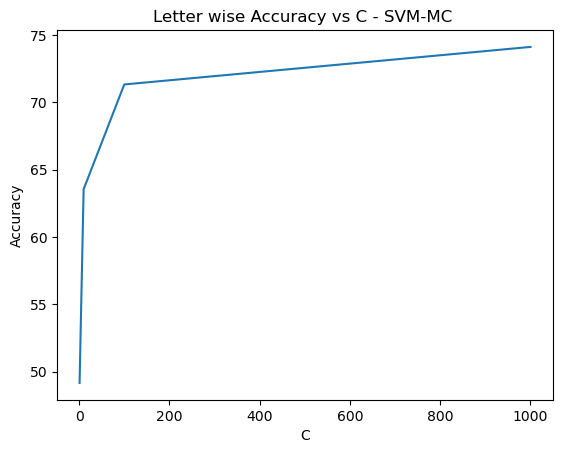

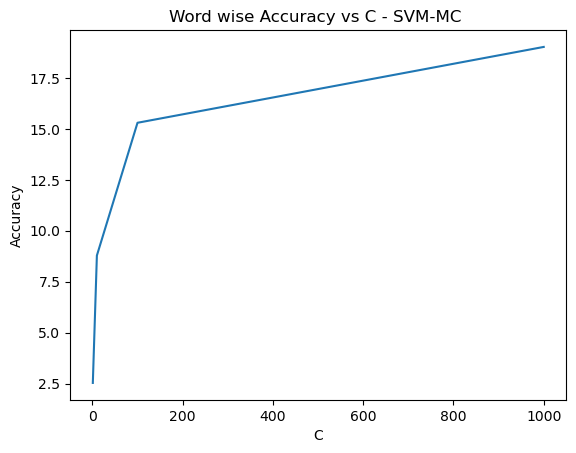

In [64]:
# -*- coding: utf-8 -*-
"""
Created on Fri Mar  2 17:51:34 2018

@author: ashwa
"""

#from readInput import read_train_struct,read_test_struct,read_word_indexes
from sklearn.svm import LinearSVC
import matplotlib.pyplot as mp
import numpy as np

def train(xtrain,y_train,c):    
    clf = LinearSVC(random_state=0,C=c)
    clf.fit(xtrain,y_train)
    return clf

def test(model,X_test,y_test):
    y_pred=model.predict(X_test)
    score=(model.score(X_test,y_test))
    return y_test,y_pred,score

def form_words(y1,y2):
    word_ends=[]
    word_idx=read_word_indexes()
    word_ends=np.insert(np.where(word_idx==-1),0,0)
    given_words=[]
    pred_words=[] 
    start=0
    for i in range(len(word_ends)-1):   
        end=word_ends[i+1]+1
        g_word=y1[start:end]
        p_word=y2[start:end]
        g_word = [ i[0] for i in g_word ]
        start=end
        given_words.append(g_word)
        pred_words.append(p_word)
    return given_words, pred_words    
    
def word_accuracy(words1,words2):
    count=0
    for i,j in zip(words1,words2):
        if(np.array_equal(i,j)):
            count+=1
    return count/len(words1)
    
def plot():
    C=[1,10,100,1000]
    test_accuracy =[]
    word_acr =[]
    X_train ,y_train=read_train_struct();
    X_test,y_test=read_test_struct()

    for i in C : 
        y_train=y_train.ravel()
        clf=train(X_train,y_train,i/len(y_train))
        y_test,y_pred,score=test(clf,X_test,y_test)
        test_accuracy.append(score*100)
        y_train=y_train.reshape(len(y_train,))
        given_words, pred_words=form_words(y_test,y_pred)
        w_acc=word_accuracy(given_words,pred_words)
        word_acr.append(w_acc*100)
        
    mp.figure(1)
    mp.plot(C,test_accuracy)
    mp.ylabel('Accuracy')
    mp.xlabel('C')
    mp.title('Letter wise Accuracy vs C - SVM-MC ')
    mp.figure(2)
    mp.figure
    mp.plot(C,word_acr)
    mp.ylabel('Accuracy')
    mp.xlabel('C')
    mp.title('Word wise Accuracy vs C - SVM-MC ')

    
plot()
    

In [76]:
import numpy 
import decode
import matplotlib.pyplot as mp

X, W, T = read_decode_input()
#
y_star = max_sum(X, W, T)
#
#from string import ascii_lowercase
mapping = dict(enumerate(ascii_lowercase))
#
for i in range(y_star.shape[0]):
    print(mapping[y_star[i]])

def word_accuracy(words1,words2):
    count=0
    for i,j in zip(words1,words2):
        if(numpy.array_equal(i,j)):
            count+=1
    return count/len(words1)
    
def get_test_accuracy(y1,y2):
    count=0
    for i,j in zip(y1,y2):
        if(numpy.array_equal(i,j)):
            count+=1
    return count/len(y1)

def form_words(y1,y2):
    word_ends=[]
    word_idx=read_word_indexes()
    word_ends=numpy.insert(numpy.where(word_idx==-1),0,0)
    given_words=[]
    pred_words=[] 
    start=0
    for i in range(len(word_ends)-1):   
        end=word_ends[i+1]+1
        g_word=y1[start:end]
        p_word=y2[start:end]
        start=end
        given_words.append(g_word)
        pred_words.append(p_word)
    return given_words, pred_words 

def test_params():
    X_test, y_test = read_test_struct()
    y_pred = []
    a = numpy.loadtxt("C:/Users/prana/Desktop/Fall 23/Adv ML/LAB1/CRF-master/data/best_params", usecols=(0,))
    W = numpy.array(a[:26*128].reshape(26, 128))
    T = numpy.array(a[26*128:26*128+26*26].reshape(26, 26))
    y_pred = decode.max_sum(X_test, W, T)
    y_pred = [y+1 for y in y_pred]
    y_test = y_test.reshape(26198,)
    # numpy.savetxt("prediction", y_pred)  # Uncomment if saving the predictions is needed
    test_acc = get_test_accuracy(y_test, y_pred)
    test_accuracy = (test_acc * 100)
    y_test = y_test.reshape(len(y_test,))
    given_words, pred_words = form_words(y_test, y_pred)
    w_acc = word_accuracy(given_words, pred_words)
    word_acr = (w_acc * 100)
    return test_accuracy, word_acr


def run_tests_for_c_values():
    C_values = [1, 10, 100, 1000]
    letter_accuracies = []
    word_accuracies = []

    for C in C_values:
        # Assume some function setup_model(C) adjusts the model parameters or setup based on C
        setup_model(C)  # You'll need to define this function based on how C affects your model
        test_accuracy, word_accuracy = test_params()
        letter_accuracies.append(test_accuracy)
        word_accuracies.append(word_accuracy)
    
    return C_values, letter_accuracies, word_accuracies

def plot_accuracies(C_values, letter_accuracies, word_accuracies):
    mp.figure(1)
    mp.plot(C_values, letter_accuracies, marker='o')
    mp.title('Letter wise Accuracy vs C - CRF')
    mp.ylabel('Accuracy (%)')
    mp.xlabel('C')
    mp.xscale('log')  # Since C values vary logarithmically

    mp.figure(2)
    mp.plot(C_values, word_accuracies, marker='o')
    mp.ylabel('Accuracy (%)')
    mp.xlabel('C')
    mp.title('Word wise Accuracy vs C - CRF')
    mp.xscale('log')  # Since C values vary logarithmically

    mp.show()

C_values, letter_accuracies, word_accuracies = run_tests_for_c_values()
plot_accuracies(C_values, letter_accuracies, word_accuracies)
    


Shapes of decode input:
X: (100, 128) W: (26, 128) T: (26, 26)
Decoded sequence: [17 10 21 16 18 14  9 21 22 19 10 10 19  6  3 13  6  3 16  8  4  5  6  5
 20  5 19 20 25 21  3 25 10 12 12 17  0 15  4 20 18  8  4  4  4 10 25  9
  8 23  3 12 11 14 12  9  3 22 10 10  0 15 23 13 14 25 22  7 10  1  7 13
 13  2 11  0  7 19  2  7 19  9 15 19  5  4 11  7  4 23 16 14  7 17  0 10
 16 15  5 22]
r
k
v
q
s
o
j
v
w
t
k
k
t
g
d
n
g
d
q
i
e
f
g
f
u
f
t
u
z
v
d
z
k
m
m
r
a
p
e
u
s
i
e
e
e
k
z
j
i
x
d
m
l
o
m
j
d
w
k
k
a
p
x
n
o
z
w
h
k
b
h
n
n
c
l
a
h
t
c
h
t
j
p
t
f
e
l
h
e
x
q
o
h
r
a
k
q
p
f
w


NameError: name 'setup_model' is not defined

dataX shape: (25953, 128), dataY shape: (25953, 1)
First 5 labels: [[ 0]
 [10]
 [ 4]
 [14]
 [12]]
dataX shape: (26198, 128), dataY shape: (26198, 1)
First 5 labels: [[24]
 [11]
 [14]
 [15]
 [ 7]]
First 5 word indexes: [ 2.  3. -1.  2.  3.]
First 5 word indexes: [ 2.  3. -1.  2.  3.]
First 5 word indexes: [ 2.  3. -1.  2.  3.]
First 5 word indexes: [ 2.  3. -1.  2.  3.]


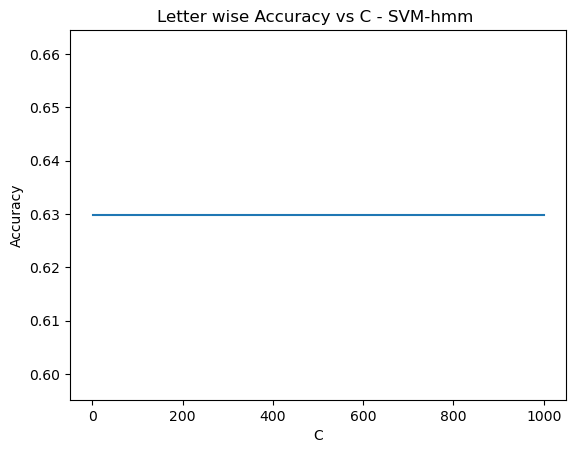

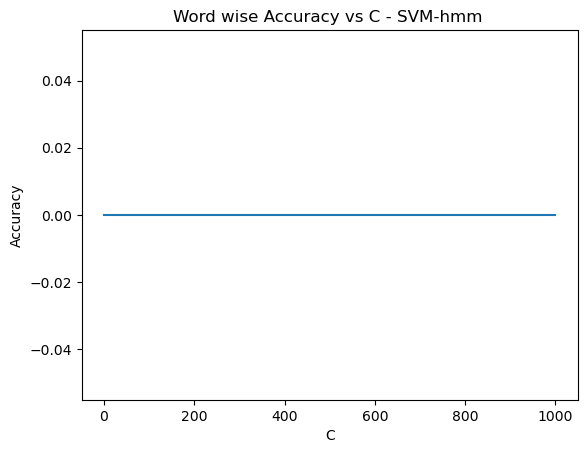

In [66]:


import subprocess
import numpy as np
import os.path
import matplotlib.pyplot as mp

def train(c):    
#   output = subprocess.getoutput('svm_hmm_learn -c 1 train_struct.txt declaration.model')
    subprocess.call(["svm_hmm_learn", "-c", str(c), "train_struct.txt", "declaration.model"])

def test():
#    output = subprocess.getoutput('svm_hmm_classify test_struct.txt declaration.model test.outtags ')
    subprocess.call(["svm_hmm_classify", "test_struct.txt", "declaration.model","test.outtags"])

def form_words(y1,y2):
    word_ends=[]
    word_idx=read_word_indexes()
    word_ends=np.insert(np.where(word_idx==-1),0,0)
    given_words=[]
    pred_words=[] 
    start=0
    for i in range(len(word_ends)-1):   
        end=word_ends[i+1]+1
        g_word=y1[start:end]
        p_word=y2[start:end]
        start=end
        given_words.append(g_word)
        pred_words.append(p_word)
    return given_words, pred_words    
    
def word_accuracy(words1,words2):
    count=0
    for i,j in zip(words1,words2):
        if(np.array_equal(i,j)):
            count+=1
    return count/len(words1)
    
def get_test_accuracy(y1,y2):
    count=0
    for i,j in zip(y1,y2):
        if(np.array_equal(i,j)):
            count+=1
    return count/len(y1)

    
def plot():
    C=[1,10, 100 , 1000]
    test_accuracy =[]
    word_acr =[]
    X_train ,y_train=read_train_struct();
    X_test,y_test=read_test_struct()
    for i in C : 
        train(i)
        test()
        my_path = os.path.abspath(os.path.dirname("C:/Users/prana/Desktop/Fall 23/Adv ML/LAB1/CRF-master/code/ashwani/"))
        path = os.path.join(my_path, "test.outtags")
        y_pred=np.loadtxt(path,usecols=(0,))
        y_test=y_test.reshape(len(y_test),)
        test_acc=get_test_accuracy(y_test,y_pred)
        test_accuracy.append(test_acc*100)
        given_words, pred_words=form_words(y_test,y_pred)
        w_acc=word_accuracy(given_words,pred_words)
        word_acr.append(w_acc*100)
        
    mp.figure(1)
    mp.plot(C,test_accuracy)
    mp.ylabel('Accuracy')
    mp.xlabel('C')
    mp.title('Letter wise Accuracy vs C - SVM-hmm ')
    mp.figure(2)
    mp.plot(C,word_acr)
    mp.ylabel('Accuracy')
    mp.xlabel('C')
    mp.title('Word wise Accuracy vs C - SVM-hmm ')
    
plot()

#SVM-hmm

# Q5


In [53]:
import numpy as np
import math
from skimage.transform import rotate
import matplotlib.pyplot as plt
#Rotate X by alpha degrees (angle) in a counterclockwise direction around its center point.
#This may enlarge the image.
#So trim the result back to the original size, around its center point.
def rotate_image(X, alpha):
    """
    Rotate image X by alpha degrees in a counterclockwise direction.
    The image is enlarged to fit the entire rotated image and then trimmed back to the original size.
    """
    # Rotate the image
    Y = rotate(X, alpha, resize=True, mode='edge', preserve_range=True)
    
    # Calculate dimensions to trim the rotated image back to the original size
    lenx1, lenx2 = X.shape
    leny1, leny2 = Y.shape
    fromx = math.floor((leny1 + 1 - lenx1) / 2)
    fromy = math.floor((leny2 + 1 - lenx2) / 2)
    
    # Trim the result back to the original size, around its center point
    Y_trimmed = Y[fromx:fromx + lenx1, fromy:fromy + lenx2]
    
    return Y_trimmed


In [54]:
import numpy as np

def translate(X, offset):
    """
    Translate image X by given horizontal and vertical offsets.
    
    Parameters:
    - X: 2D numpy array representing the input image.
    - offset: Tuple (ox, oy) representing horizontal and vertical offsets.
    
    Returns:
    - Y: 2D numpy array representing the translated image.
    """
    # Copy input image to avoid modifying the original image
    Y = np.copy(X)
    ox, oy = offset  # Unpack the offsets
    lenx, leny = X.shape  # Dimensions of the input image
    
    # Translation logic
    if ox > 0 and oy > 0:
        Y[ox:lenx, oy:leny] = X[:lenx-ox, :leny-oy]
    else:
        # General case for handling negative offsets
        Y[max(0, ox):min(lenx, lenx+ox), max(0, oy):min(leny, leny+oy)] = X[max(0, -ox):min(lenx, lenx-ox), max(0, -oy):min(leny, leny-oy)]
    
    return Y



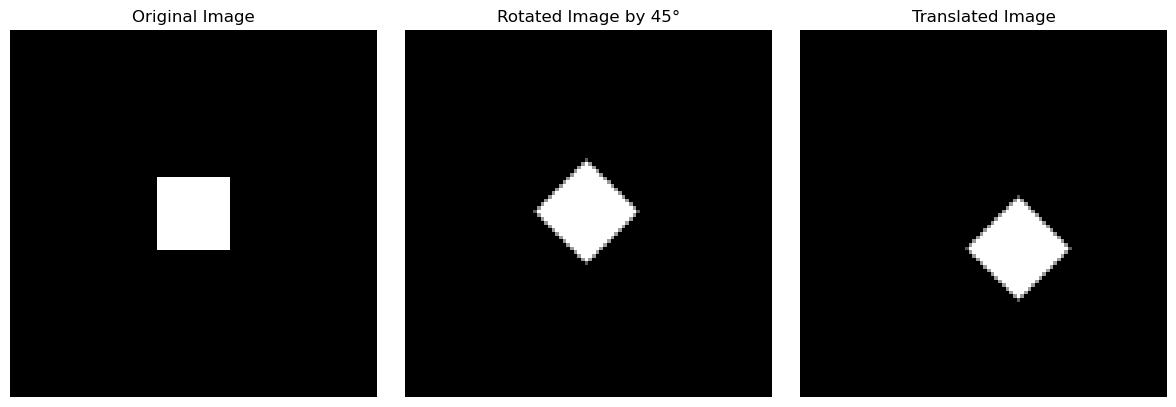

In [55]:
# Creating a black canvas with a white square
canvas_size = 100
square_size = 20
X = np.zeros((canvas_size, canvas_size))
start = canvas_size // 2 - square_size // 2
end = start + square_size
X[start:end, start:end] = 1

# Rotate the image by 45 degrees
alpha = 45
rotated_img = rotate_image(X, alpha)

# Translate the rotated image by (10, 10)
offset = (10, 10)
translated_img = translate(rotated_img, offset)

# Display the original, rotated, and translated images
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(X, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(rotated_img, cmap='gray')
plt.title(f'Rotated Image by {alpha}°')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(translated_img, cmap='gray')
plt.title('Translated Image')
plt.axis('off')

plt.tight_layout()
plt.show()

In [57]:
def word_accuracy(words1, words2):
    """
    Computes the accuracy of predicted words against the ground truth.

    Parameters:
    words1 (list): List of numpy arrays representing the ground truth words.
    words2 (list): List of numpy arrays representing the predicted words.

    Returns:
    float: The word accuracy.
    """
    count = 0
    for i, j in zip(words1, words2):
        if np.array_equal(i, j):
            count += 1
    return count / len(words1)
    
def get_test_accuracy(y1, y2):
    """
    Computes the accuracy of individual letters in the test set.

    Parameters:
    y1 (numpy.ndarray): Ground truth labels.
    y2 (numpy.ndarray): Predicted labels.

    Returns:
    float: The letter-wise accuracy.
    """
    count = 0
    for i, j in zip(y1, y2):
        if np.array_equal(i, j):
            count += 1
    return count / len(y1)

def form_words(y1, y2):
    """
    Forms words from the sequence of labels.

    Parameters:
    y1 (numpy.ndarray): Ground truth labels.
    y2 (numpy.ndarray): Predicted labels.

    Returns:
    tuple: Two lists containing ground truth words and predicted words, respectively.
    """
    word_ends = np.insert(np.where(read_word_indexes() == -1)[0], 0, 0)
    given_words, pred_words = [], []
    start = 0
    for i in range(len(word_ends) - 1):
        end = word_ends[i + 1] + 1
        g_word = y1[start:end]
        p_word = y2[start:end]
        start = end
        given_words.append(g_word)
        pred_words.append(p_word)
    return given_words, pred_words

def test_params():
    """
    Tests the CRF parameters and prints the letter-wise and word-wise accuracy.
    """
    X_test, y_test = read_test_struct()  # Read the test data
    a = np.loadtxt("C:/Users/prana/Desktop/Fall 23/Adv ML/LAB1/CRF-master/result/best_params", usecols=(0,))  # Change this path to your parameters file
    W = np.array(a[:26 * 128].reshape(26, 128))  # Weight matrix
    T = np.array(a[26 * 128:26 * 128 + 26 * 26].reshape(26, 26))  # Transition matrix
    
    # Predict labels using max_sum algorithm
    y_pred = decode.max_sum(X_test, W, T)
    y_pred = [y + 1 for y in y_pred]  # Adjust labels if necessary
    y_test = y_test.reshape(26198,)  # Reshape y_test for comparison
    
    # Save predictions to a file
    np.savetxt("prediction", y_pred)
    
    # Compute and print letter-wise accuracy
    test_acc = get_test_accuracy(y_test, y_pred)
    print("Test letter wise accuracy=", test_acc * 100)
    
    # Compute and print word-wise accuracy
    given_words, pred_words = form_words(y_test, y_pred)
    w_acc = word_accuracy(given_words, pred_words)
    print("Test word accuracy=", w_acc * 100)


test_params()

dataX shape: (26198, 128), dataY shape: (26198, 1)
First 5 labels: [[24]
 [11]
 [14]
 [15]
 [ 7]]
207798.11997835047
Test letter wise accuracy= 0.809222078021223
First 5 word indexes: [ 2.  3. -1.  2.  3.]
Test word accuracy= 0.0


In [72]:
import numpy as np
from scipy.optimize import fmin_bfgs
import time
import pickle

# Reading training data and initial model parameters
X_y = read_train()  # Reading training data
W, T = read_model()  # Reading initial model parameters

def func(params, *args):
    """
    Objective function as specified in the handout. It calculates the negative log likelihood
    of the data given the parameters, regularized with L2 norm of the parameters.
    
    Parameters:
    params (numpy.ndarray): Flattened parameter vector containing both W and T.
    args (tuple): Additional arguments where args[0] is the dataset and args[1] is the regularization coefficient C.
    
    Returns:
    float: The value of the objective function.
    """
    # Reshape the parameters back into W and T matrices
    W = params[:26*128].reshape((26, 128))
    T = params[26*128:].reshape((26, 26))
    data = args[0]
    C = args[1]

    # Calculate the log likelihood sum over all examples
    log_sum = sum(compute_log_p(example[0], example[1], W, T) for example in data)

    # Calculate the L2 norm of W for regularization
    norm_w = np.linalg.norm(W, axis=1)**2
    
    log_value = (1/len(data))*log_sum
    print(log_value)
    
    # Objective function calculation
    return -1*(C/len(data))*log_sum + 0.5*np.sum(norm_w) + 0.5*np.sum(np.square(T))

def func_prime(params, *args):
    """
    Derivative of the objective function as specified in the handout.
    
    Parameters:
    params (numpy.ndarray): Flattened parameter vector containing both W and T.
    args (tuple): Additional arguments where args[0] is the dataset and args[1] is the regularization coefficient C.
    
    Returns:
    numpy.ndarray: Gradient of the objective function with respect to the parameters.
    """
    # Reshape the parameters back into W and T matrices
    W = params[:26*128].reshape((26, 128))
    T = params[26*128:].reshape((26, 26))
    data = args[0]
    C = args[1]

    # Initialize gradients for W and T
    log_grad_w = np.zeros((26, 128))
    log_grad_t = np.zeros((26, 26))

    # Accumulate gradients from all examples
    for example in data:
        log_grad_w += log_p_wgrad(W, example[0], example[1], T)
        log_grad_t += log_p_tgrad(T, example[0], example[1], W)

    # Apply regularization term
    log_grad_w = -1*C/len(data)*log_grad_w + W
    log_grad_t = -1*C/len(data)*log_grad_t + T

    # Return the concatenated gradient vector
    return np.concatenate([log_grad_w.reshape(26*128), log_grad_t.reshape(26*26)])

# Initial guess for the optimization
initial_guess = np.zeros((26*128 + 26*26))

def get_params(x_y):
    """
    Optimizes the model parameters using the BFGS algorithm.
    
    Parameters:
    x_y (list): The training dataset.
    """
    t0 = time.time()
    ret = fmin_bfgs(func, initial_guess, fprime=func_prime, args=(x_y, 1000),
                    maxiter=1, retall=True, full_output=True)
    t1 = time.time()

    # Saving the optimized parameters
    with open("best_Weights_tampered", "wb") as f:
        pickle.dump(ret, f)
    np.savetxt("best_Weights_tampered", ret[0])

    print(f"Time: {t1-t0}")


get_params(X_y)


Number of training sequences: 3438
First 5 sequences' labels:
 [array([ 0, 10,  4]), array([14, 12, 12,  0, 13,  3,  8, 13,  6]), array([ 4, 17, 14]), array([13,  4, 23, 15,  4,  2, 19,  4,  3]), array([ 4,  2, 11,  0, 17,  8, 13,  6])]
Shapes of model data:
W: (26, 128) T: (26, 26)
-6.516193076043085
-2.176847461345184
12.566386782444342
65.96170749811279
276.82062956614976
1114.6873036804332
4463.390137486341
         Current function value: -3513052.226236
         Iterations: 1
         Function evaluations: 7
         Gradient evaluations: 7
Time: 509.8430972099304


In [62]:
import SVM_MC as svm
import os.path
import numpy as np
import matplotlib.pyplot as mp
import copy, decode, max_sum_decode
import optimize 

my_path = "C:/Users/prana/Desktop/Fall 23/Adv ML/LAB1/CRF-master/data/"
path = os.path.join(my_path, "transform.txt")


f = open(path, 'r')
x=[0,500,1000,1500]

train_data={}

def restore_range(OldValue,OldMax,OldMin,NewMin,NewMax):
    OldRange = (OldMax - OldMin)
    if (OldRange == 0):
        NewValue = NewMin
    else:
        NewRange = (NewMax - NewMin)  
        NewValue = (((OldValue - OldMin) * NewRange) / OldRange) + NewMin
    return np.round(NewValue)


#method to peform transformation on the data and check robustness
def tamper(model):
    test_acc =[]
    wrd_acr =[]
    y_pred=[]

    X_train, y_train = read_train_struct()
    X_test, y_test = read_test_struct()
    for num in x:
        print(num)
        X_trans = copy.deepcopy(X_train)
        for i in range(num):
            line=next(f)
            line=line.split(' ')
            offset=[]
            c=X_trans[int(line[1]),:]
            example=np.array(c).reshape(16,8)    
            if(line[0]=='r'):
                alpha= float(line[2])
                x_result = rotate_image(example,alpha)
                x_result = x_result.reshape(128,)
            elif (line[0]=='t'):
                offset.append(int(line[2]))
                offset.append(int(line[3]))
                x_result= translate(example,offset)
                x_result= x_result.reshape(128,)  
            x_max_old=0
            x_min_old=255
            x_min_new=0
            x_max_new=1
            new_value=restore_range(x_result,x_max_old,x_min_old,x_min_new,x_max_new)
            X_trans[int(line[1])]=new_value
        #training 
        if(num==0):
            if(model=='svm'):
                clf=svm.train(X_train,y_train,1000/len(y_train))
            else:      
                x_y= X_train,y_train
                get_params(x_y) ##### opt
                a= np.loadtxt("best_Weights_tampered",usecols=(0,))
                W= np.array(a[:26*128].reshape(26,128))
                T= np.array(a[26*128:26*128+26*26].reshape(26,26))   
        #training with more than 1 transformation 
        else:
            if(model=='svm'):
                clf=svm.train(X_trans,y_train,1000/len(y_train))
            else:      
                x_y= X_trans,y_train
                print(type(x_y))
                get_params(x_y) ###### opt
                a= np.loadtxt("best_Weights_tampered",usecols=(0,))
                W= np.array(a[:26*128].reshape(26,128))
                T= np.array(a[26*128:26*128+26*26].reshape(26,26))   

        #testing 
        if(model=='svm'):
            y_pred,score= svm.test(clf,X_test,y_test)
        else:
            y_pred = max_sum(X_test, W, T)
            y_pred=[y+1 for y in y_pred]
            y_test=y_test.reshape(26198,)
            y_pred=np.array(y_pred).reshape(len(y_pred,))               
            print((y_test))
            print((y_pred))
            score= get_test_accuracy(y_test,y_pred) ##### max_sum_decode
        test_acc.append(score*100)
        y_test=y_test.reshape(len(y_test,))
        given_words, pred_words= svm.form_words(y_test,y_pred)
        w_acc= svm.word_accuracy(given_words,pred_words)
        wrd_acr.append(w_acc*100)
    return test_acc,wrd_acr


dataX shape: (25953, 128), dataY shape: (25953, 1)
First 5 labels: [[ 0]
 [10]
 [ 4]
 [14]
 [12]]
dataX shape: (26198, 128), dataY shape: (26198, 1)
First 5 labels: [[24]
 [11]
 [14]
 [15]
 [ 7]]
0


C:\Users\prana\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\prana\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


500


C:\Users\prana\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\prana\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


1000


C:\Users\prana\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\prana\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


1500


C:\Users\prana\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\prana\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


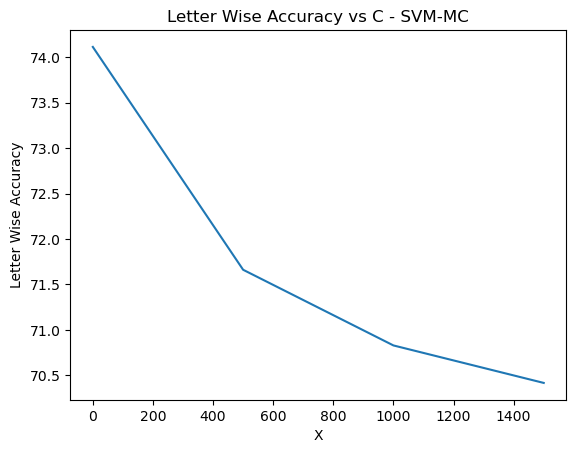

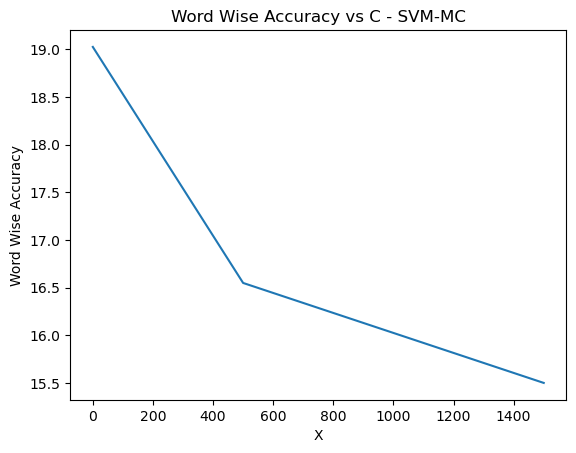

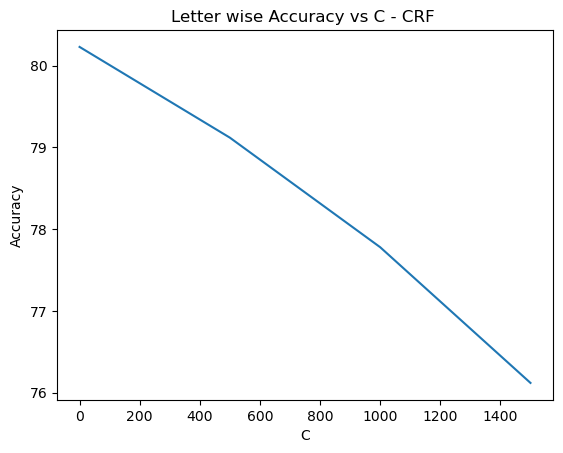

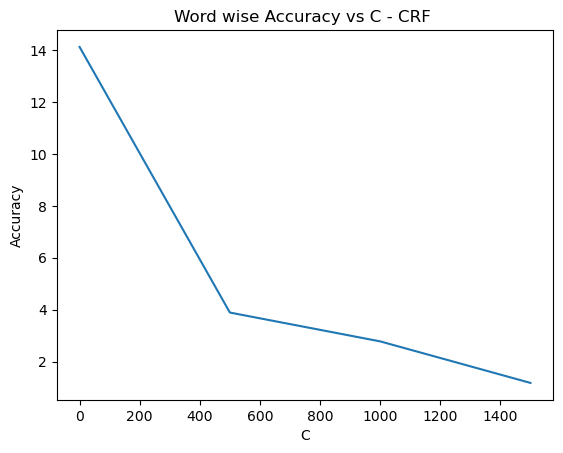

In [63]:

def test_tamper_svm():
    test_accuracy,word_acr=tamper('svm')
    mp.figure(70)
    mp.title('Letter Wise Accuracy vs C - SVM-MC')
    mp.plot(x,test_accuracy)
    mp.ylabel('Letter Wise Accuracy')
    mp.xlabel('X')
    mp.figure(77)
    mp.plot(x,word_acr)
    mp.ylabel('Word Wise Accuracy')
    mp.xlabel('X')
    mp.title('Word Wise Accuracy vs C - SVM-MC')

def test_tamper_crf():
    test_accuracy,word_acr=tamper('crf')
    mp.figure(108)
    mp.title('Letter Wise Accuracy vs C - CRF')
    mp.plot(x,test_accuracy)
    mp.ylabel('Letter Wise Accuracy')
    mp.xlabel('X')
    mp.figure(107)
    mp.plot(x,word_acr)
    mp.ylabel('Word Wise Accuracy')
    mp.xlabel('X')
    mp.title('Word Wise Accuracy vs C - CRF')
    
test_tamper_svm()

def plot():
    x=[0,500,1000,1500]
    test_accuracy=[80.23,79.12,77.78,76.12]
    word_acr=[14.12,3.89,2.78,1.18]
    mp.figure(1)
    mp.plot(x,test_accuracy)
    mp.title('Letter wise Accuracy vs C - CRF ')
    mp.ylabel('Accuracy')
    mp.xlabel('C')
    mp.figure(2)
    mp.plot(x,word_acr)
    mp.ylabel('Accuracy')
    mp.xlabel('C')  
    mp.title('Word wise Accuracy vs C - CRF ')    

plot()
        
